# Predicting Global Desalination Prices through Machine Learning
Primary Objective: Using Ordinary Least Squares (OLS) Regression estimate the installation price of a desalination plant given any one or combination of the following parameters: location in the world, feedwater type, customer type, plant type, membrane type, system type.

Note: Installation Price is defined as EPC (Engineering, Procurement, Construction) price


<h3>Load required libraries</h3>

In [1]:
import configparser #install as  ConfigParser
import pandas as pd
import pandas_profiling as ppf
import numpy as np
import dropbox
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import math
import gmaps

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel("solar_desaldata v2.0.xlsx")
df.head()

,Country,Region,Subregion,Location,State/Region,Location type,Project name,Capacity (m3/d),Size,Capacity (MGD),...,MED Gain Output Ratio,MSF Design,MSF System,MSF Equipment,MSF Type,MSF Geometry,MSF Configuration,MSF Heat Recovery Stages,MSF Heat Rejection Stages,MSF Gain Output Ratio
0,U.K.,EMEA,Western Europe,Preston,England,Land based,Preston,326.0,S,0.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,India,Asia Pacific,Southern Asia,Andaman Island,Andaman and Nicobar Islands,Land based,Andaman Island,302.0,S,0.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,U.K.,EMEA,Western Europe,Dunston,NaN,Land based,Dunston,1005.0,M,0.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,U.K.,EMEA,Western Europe,Battersea,England,Land based,Battersea,806.0,S,0.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,U.K.,EMEA,Western Europe,West Ham,NaN,Land based,West Ham,238.0,S,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19329 entries, 0 to 19328
Columns: 180 entries, Country to MSF Gain Output Ratio
dtypes: float64(51), object(129)
memory usage: 26.7+ MB


In [5]:
df.describe()

,Capacity (m3/d),Capacity (MGD),Capacity (MIGD),Units,Unit size (m3/d),Unit size (MGD),Unit size (MIGD),Award date,Unnamed: 30,Unnamed: 31,...,Bid submitted5,Pre qualified4,Pre qualified5,Statement of qualification4,Statement of qualification5,MED Power Consumption,MED Gain Output Ratio,MSF Heat Recovery Stages,MSF Heat Rejection Stages,MSF Gain Output Ratio
count,19271.000000,19271.000000,19271.000000,13952.000000,13924.000000,13924.000000,13924.000000,19078.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.000000,17.000000,27.000000,28.000000,51.000000
mean,6570.216076,1.735867,1.445231,1.822104,1823.889632,0.481966,0.401011,1997.748244,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.220000,8.797059,16.259259,2.750000,7.719216
std,31202.984389,8.243873,6.863911,7.309046,6052.168448,1.598976,1.331412,13.582555,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.462514,2.388807,4.319834,0.440959,1.474850
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1944.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.950000,5.000000,6.000000,2.000000,3.020000
25%,265.500000,0.070000,0.060000,1.000000,210.000000,0.060000,0.050000,1988.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.300000,7.100000,13.000000,2.750000,7.000000
50%,737.000000,0.190000,0.160000,1.000000,500.000000,0.130000,0.110000,2000.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.350000,8.500000,17.000000,3.000000,8.000000
75%,2650.000000,0.700000,0.580000,2.000000,1363.000000,0.360000,0.300000,2009.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.175000,11.000000,19.000000,3.000000,8.550000
max,909200.000000,240.210000,200.000000,600.000000,240000.000000,63.410000,52.790000,2025.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,11.000000,13.000000,23.000000,3.000000,12.000000


In [6]:
df0 = df.filter(items=['Latitude', 'Longitude'])
df1 = df.filter(items=['Latitude', 'Longitude','Inflation Adjusted EPC'])
df2 = df.filter(items=['Latitude', 'Longitude','Capacity (m3/d)'])
df4 = pd.read_csv("solar_desal_with_h2o.csv")
df3 = df4.filter(items=['Latitude', 'Longitude','Inflation Adjusted Water Cost'])
df0 = df0.dropna()
df1 = df1.dropna()
df2 = df2.dropna()
df3 = df3.dropna()


### ASK MICHAEL

In [7]:
locations = df0
fig = gmaps.figure(map_type='HYBRID')
heatmap_layer = gmaps.heatmap_layer(locations)
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

### ASK MICHAEL

In [8]:
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(df1[['Latitude', 'Longitude']], weights=df1['Inflation Adjusted EPC'],
max_intensity=38700000, point_radius=3.0
)
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [9]:

fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(df2[['Latitude', 'Longitude']], weights=df2['Capacity (m3/d)'],
max_intensity=8000, point_radius=3.0
)
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

## Data Manipulation and Data Cleaning

In [10]:
df = pd.read_csv('solar_desaldata v4.0.csv', encoding ="ISO-8859-1")
df_water = pd.read_excel('water_stress.xlsx', 'Baseline Water Stress')
df = df.set_index('Country').join(df_water.set_index('Country')).reset_index()

df_ngp = pd.read_excel('NGP.xls',sheet_name='Data 1')
df = df.set_index('Award date').join(df_ngp.set_index('Award date')).reset_index()
#Water Stress, Inflation Adjusted Wellhead Natural Gas Price
df['Water Stress'] = df['Water Stress'].replace('-',np.NaN)

In [11]:
type(df["Capacity (m3/d)"][0]) 

str


#### Convert columns to right format


In [12]:
def convert(v):
    try:
        x = str(v).replace(",","")
        x = float(x)
        return x
    except Exception as e:
        print(e)
        return None
df["Capacity (m3/d)"] = df["Capacity (m3/d)"].apply(convert)
type(df["Capacity (m3/d)"][0])

numpy.float64

### Here we go through a series of steps to remove missing and outlier data points. At the start of the exercise we have 18k records

### Adjusting for Inflation
In the first plot we show EPC Price over time. Deductions:
1. Presence of Outliers. To solve this we remove top % and least 5% values.
2. Upward Sloping Curve. To solve for this we adjusted the price in our offline flat file to produce Inflation Adjusted EPC (presented in the second plot).


### EPC vs Online Date

<Figure size 2016x1296 with 0 Axes>

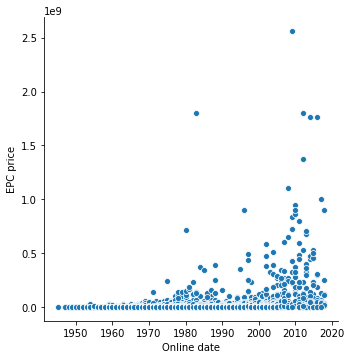

<Figure size 2016x1296 with 0 Axes>

In [13]:
ax = sns.pairplot(x_vars=["Online date"], y_vars=["EPC price"], data=df, size=5)
plt.figure(figsize=(28, 18))

Keep positive price records (implicitely removes 0's and nulls)

Remove records exceeding the 5th and 95th bounds for outliers

In [14]:
print("Initial file size " + str(len(df)))

df = df[df['Inflation Adjusted EPC']>0]
print("New file size "+str(len(df)))

Initial file size 18741
New file size 9728


#### Removing Outliers

In [15]:
minbound = df['Inflation Adjusted EPC'].quantile(q=0.05)
maxbound = df['Inflation Adjusted EPC'].quantile(q=0.95)
df = df[df['Inflation Adjusted EPC']<=maxbound]
df = df[df['Inflation Adjusted EPC']>=minbound]
print("New file size "+str(len(df)))

New file size 8748


### EPC vs Online Date After Removing Outliers

<Figure size 2016x1296 with 0 Axes>

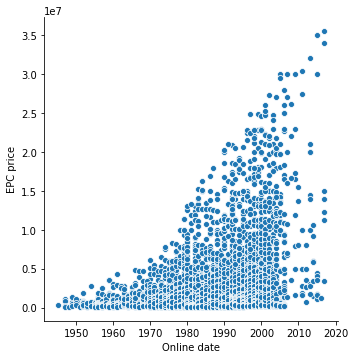

<Figure size 2016x1296 with 0 Axes>

In [16]:
ax = sns.pairplot(x_vars=["Online date"], y_vars=["EPC price"], data=df, size=5)
plt.figure(figsize=(28, 18))

### EPC vs Online Date  After Adjusting for Inflation

<Figure size 2016x1296 with 0 Axes>

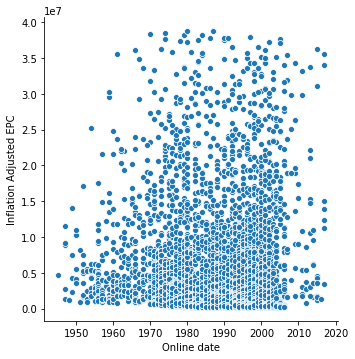

In [17]:
plt.figure(figsize=(28, 18))
sns.pairplot(x_vars=["Online date"], y_vars=["Inflation Adjusted EPC"], data=df, size=5)

#### EPC vs Online Date After Adjusting for Inflation wrt Technology


<Figure size 2520x1296 with 0 Axes>

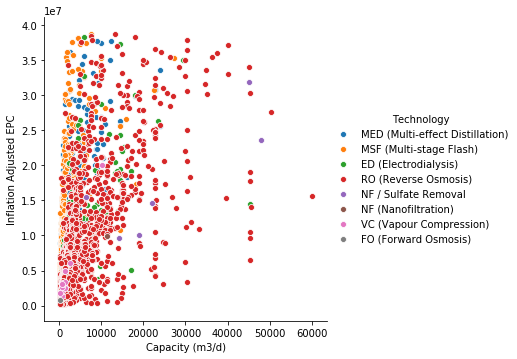

<Figure size 2520x1296 with 0 Axes>

In [18]:
# df1=df[df["Capacity (m3/d)"]<100000]
sns.pairplot(x_vars=["Capacity (m3/d)"], y_vars=["Inflation Adjusted EPC"], data=df, hue="Technology", size=5)
plt.figure(figsize=(35, 18))

### Inflation Adjusted EPC vs Capacity(MGD)

<Figure size 2520x1296 with 0 Axes>

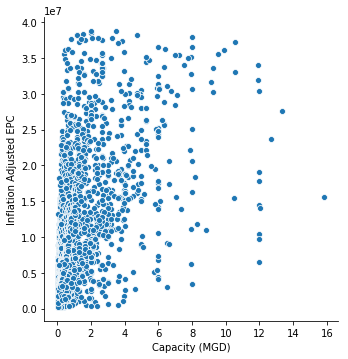

<Figure size 2520x1296 with 0 Axes>

In [19]:
# df1=df[df["Capacity (m3/d)"]<100000]
sns.pairplot(x_vars=["Capacity (MGD)"], y_vars=["Inflation Adjusted EPC"], data=df, size=5)
plt.figure(figsize=(35, 18))

### Looking at the relationship of Price across multiple fields, we also noticed Capacity (MGD) has a non-linear relationship with EPC. Based on a training subset, we saw a sqrt(log(x+1)) transform pushes towards a linear relationship.

<Figure size 2016x1296 with 0 Axes>

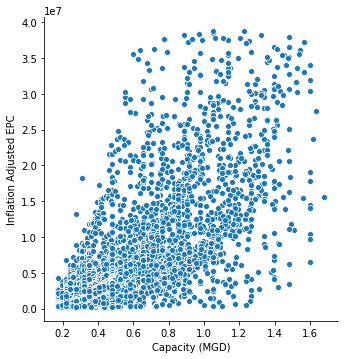

<Figure size 2016x1296 with 0 Axes>

In [20]:
df['Capacity (MGD)'] = df['Capacity (MGD)'].apply(lambda x:(math.sqrt(math.log(x+1))))
ax = sns.pairplot(x_vars=["Capacity (MGD)"], y_vars=["Inflation Adjusted EPC"], data=df, size=5)
plt.figure(figsize=(28, 18))


<h3>Review Profile Report for Missing Data</h3>
The report shows us a number of columns have missing elements. Fields with significant missing values are removed immediately. Other fields that we know are important for price estimates are kept and later imputed. 

In [21]:
pf = ppf.ProfileReport(df)
pf

Number of variables,184
Number of observations,8748
Total Missing (%),72.7%
Total size in memory,12.3 MiB
Average record size in memory,1.4 KiB
Numeric,17
Categorical,100
Boolean,3
Date,0
Text (Unique),0
Rejected,63


In [22]:
#After reviewing the ppf report and keeping features with at least 50% observation, then adding back features known to have high impact (such as prices), we ended with the following feature set:
# 'Award date','Capacity (m3/d)','Capacity (MGD)', 'Capital Cost per Unit of Daily Capacity ($/m3/d)','Country','Customer type','EPC contractor (desal)','EPC price','Feedwater','Holding Company',Inflation Adjusted EPC','Latitude','Location','Location','Location type','Location type','Longitude','Membrane type (RO)','Online date','Owner - Client','Plant status','Plant supplier','Plant supplier share','Plant type','Procurement model','Project name','Region','RO Feed Pump Drive','RO Membrane Type','RO System','Size','Subregion','Technology','Thermal design','Unit size (m3/d)','Units', 'Winner', 'Water price (USD/m3)'
mdf = df[['Award date','Capacity (m3/d)','Capacity (MGD)', 'Capital Cost per Unit of Daily Capacity ($/m3/d)','Country','Customer type','EPC contractor (desal)','EPC price','Feedwater','Holding Company','Inflation Adjusted EPC','Inflation Adjusted Wellhead Natural Gas Price','Latitude','Location','Location type','Longitude','Membrane type (RO)','Online date','Owner - Client','Plant status','Plant supplier','Plant supplier share','Plant type','Procurement model','Project name','Region','RO Feed Pump Drive','RO Membrane Type','RO System','Size','Subregion','Technology','Thermal design','Unit size (m3/d)','Units', 'Winner', 'Water price (USD/m3)','Water Stress']]
print("length of mdf: "+str(len(mdf)))

length of mdf: 8748


### Scrape water prices 
The getCountryPrices goes to a website for a given country id (integer) and returns a set of variables containing the Country Name, most recent year of water prices, and the price for that year

In [23]:
def getCountryPrices(cid):
    import requests
    from bs4 import BeautifulSoup
    url = "https://database.ib-net.org/country_profile?ctry="+str(cid)+"&years=2018,2017,2016,2015,2014,2013&type=report&ent=country&mult=true&table=true&chart=false&chartType=column&lang=en&exch=1"
    response = requests.get(url)
    soup = BeautifulSoup(response.content,'lxml')
    try:
        country_name = soup.find('li',class_='active').find('span').get_text().split('Country Profile ')[1]
    except:
        country_name = None
    #print(country_name)
    year = None
    cost = None
    if(country_name != None):
        for f in soup.find_all('script'):
            if (f.get('type') == 'text/javascript'):
                if(f.get('src') == None):
                    if('Costs, US$ per m3 sold' in f.get_text()):
                        years = list()
                        for x in f.get_text().split('xAxis')[1].split('[')[1].split(']')[0].split(','):
                            try:
                                years.append(int(x))
                            except:
                                years.append(0)
                                #print('--year error')
                        #years = [int(i) for i in (f.get_text().split('xAxis')[1].split('[')[1].split(']')[0].split(','))]
                        #print(years)
                        costs = list()
                        for x in f.get_text().split('Costs, US$ per m3 sold')[1].split('data')[1].split('[')[1].split(']')[0].split(','):
                            try:
                                costs.append(float(x))
                            except:
                                costs.append(0.0)
                                #print('--cost error')
                        #costs = [float(i) for i in f.get_text().split('Costs, US$ per m3 sold')[1].split('data')[1].split('[')[1].split(']')[0].split(',')]
                        #print(costs)
                        year = max(years)
                        cost = costs[len(costs)-1]
                        break
    return country_name, year, cost

We then pass through a large set of country id's to build a dictionary of country water prices. 

In [24]:
## WARNING!! Only run this cell once, it takes a long time to run. 
##   The output has been saved to a pickle file which is read from dropbox in the next cell. 

##Pass through 300 countries to get cost of water 

#waterPrices = {}
#for i in range(300):
#    n,y,c = getCountryPrices(i)
#    waterPrices[n] = {'year':y,'cost':c}
    
##Save the waterPrices dictionary to a pickle file (saved locally, later moved to dropbox!)
#with open('waterPrices.pickle', 'wb') as handle:
#    pickle.dump(waterPrices, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Get the contents of waterPrices.pickle from dropbox 

In [25]:
waterPrices = pd.read_pickle('waterPrices.pickle')

We leverage the mapWater function as we pass through each record in our dataframe to set the year and as-of water cost

In [26]:
def mapWater(x,feat):
    if(waterPrices.get(x) == None):
        return None
    else:
        if(feat == 'year'):
            return waterPrices.get(x)['year']
        else:
            return waterPrices.get(x)['cost']

In [27]:
mdf['Water Year'] = mdf['Country'].apply(lambda x:mapWater(x,'year'))
mdf['Water Cost'] = mdf['Country'].apply(lambda x:mapWater(x,'cost'))

### Adjust for Inflation

Given the Water Year and Water Cost, we can perform a look-up from the original dataframe to find the corresponding inflation adjustment factor to correctly adjust the cost of water!

In [28]:
infl_dict = {}
infl_set = df[['Inflation Multiple','Online date']].drop_duplicates(inplace=False)
for x in range(len(infl_set)):
    infl_dict[infl_set.iloc[x]['Online date']] = infl_set.iloc[x]['Inflation Multiple']

In [29]:
def infl_map(year):
    if(infl_dict.get(year) == None):
        return 0.0
    else:
        return infl_dict.get(year)

In [30]:
mdf['Water Inflation Multiple'] = mdf['Water Year'].apply(lambda x:infl_map(x))

In [31]:
mdf['Inflation Adjusted Water Cost'] = mdf.apply(lambda x:x['Water Cost']*x['Water Inflation Multiple'],axis=1)

The water prices available only provided water cost for 2460 records across 61 countries. We will revisit this problem shortly, and will not throw out records with missing water data. 

In [32]:
mdf['Inflation Adjusted Water Cost'].describe()

count    2460.000000
mean        0.697236
std         0.930797
min         0.000000
25%         0.000000
50%         0.319698
75%         0.935423
max         7.994429
Name: Inflation Adjusted Water Cost, dtype: float64

In [33]:
water_countries = mdf[['Country','Inflation Adjusted EPC','Inflation Adjusted Water Cost']][mdf['Inflation Adjusted Water Cost']>0]['Country'].unique()
print(len(water_countries))
print(water_countries)

56
['India' 'Turkey' 'Argentina' 'Australia' 'Namibia' 'Ecuador' 'Mexico'
 'Iraq' 'Egypt' 'Kuwait' 'Chile' 'South Africa' 'Azerbaijan' 'Cyprus'
 'Nigeria' 'South Korea' 'Bahrain' 'Indonesia' 'Philippines'
 'French Polynesia' 'Pakistan' 'Honduras' 'Sudan' 'Brazil' 'Tunisia'
 'Peru' 'Northern Mariana Islands' 'Poland' 'Malaysia' 'Portugal' 'Serbia'
 'Ukraine' 'Yemen' 'Dominican Republic' 'Nicaragua' 'China' 'Jordan'
 'Russia' 'Marshall Islands' 'Belarus' 'Czech Republic' 'Colombia'
 'Hungary' 'Norway' 'Kazakhstan' 'Botswana' 'Bulgaria' 'Uzbekistan'
 'Kenya' 'Paraguay' 'Fiji' 'Guinea' 'Costa Rica' 'New Zealand' 'Vietnam'
 'Mauritius']


<h3>Final Cleaning</h3>
To prepare our data for analysis we need to remove any records with missing geolocation since this is critical for our geo clustering. We also remove 1 record with a missing Capacity.

We then split out data into training (70%) and test sets

In [34]:
print("Prior file size "+str(len(mdf)))
mdf = mdf[(mdf['Latitude'].notna()) & (mdf['Longitude'].notna())]
mdf = mdf[mdf['Capacity (MGD)'].notna()]
print("New file size "+str(len(mdf)))

Prior file size 8748
New file size 6823


In [35]:
mdf['Inflation Adjusted EPC'] = mdf['Inflation Adjusted EPC'].apply(lambda x:math.log(x))
mdf['Inflation Adjusted Wellhead Natural Gas Price'] = mdf['Inflation Adjusted Wellhead Natural Gas Price'].apply(lambda x:math.log(x+0.01))
mdf['Inflation Adjusted Water Cost'] = mdf['Inflation Adjusted Water Cost'].apply(lambda x:math.log(x+0.01))

In [36]:
msk = np.random.rand(len(mdf)) < 0.7
train = mdf[msk]
test = mdf[~msk]

<h3>Geo Clustering</h3>
In order to impute Water Costs, and later normalize continuous variables, we cluster the training set by Latitude and Longitude using K-Means. Looking at the output elbow plot, we believe a hyperparameter of k=4 is reasonable. 

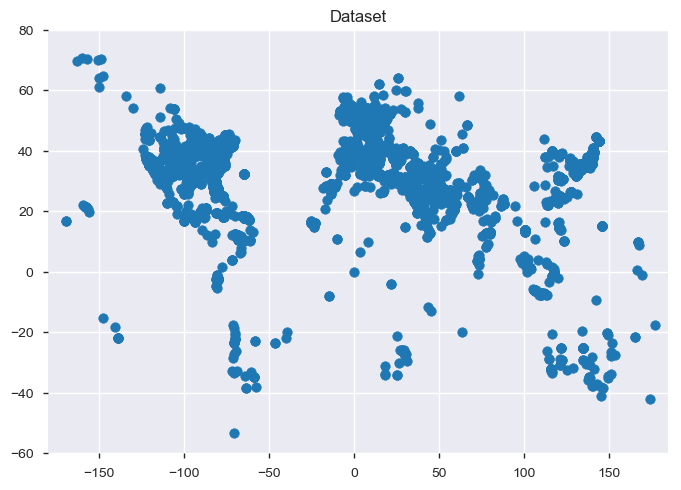

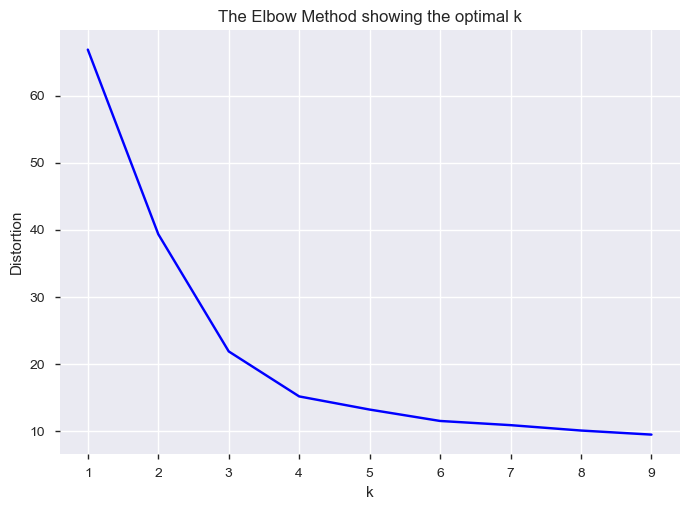

In [37]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

x2 = train['Latitude']
x1 = train['Longitude']

plt.plot()
plt.xlim([-180, 185])
plt.ylim([-60, 80])
plt.title('Dataset')
plt.scatter(x1, x2)
plt.show()

# create new plot and data
plt.plot()
X = np.array(list(zip(x1, x2))).reshape(len(x1), 2)
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [38]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(train[['Latitude','Longitude']])

Through a cursory glance it appears the clustering makes sense given the countries that appear in each cluster. Looking at a final plot of the training clusters, we feel this is a reasonable approach. 

In [39]:
print(train.iloc[np.where(kmeans.labels_ == 0)[0]]['Country'].unique())
print(train.iloc[np.where(kmeans.labels_ == 1)[0]]['Country'].unique())
print(train.iloc[np.where(kmeans.labels_ == 2)[0]]['Country'].unique())
print(train.iloc[np.where(kmeans.labels_ == 3)[0]]['Country'].unique())

['Iran' 'Turkey' 'India' 'Iraq' 'Egypt' 'Kuwait' 'Saudi Arabia'
 'Azerbaijan' 'Cyprus' 'Bahrain' 'Qatar' 'Syria' 'Sudan'
 'United Arab Emirates' 'Lebanon' 'Israel' 'Oman' 'South Africa' 'Libya'
 'Republic of Djibouti' 'Yemen' 'Russia'
 'Democratic Republic of the Congo' 'Jordan' 'Pakistan' 'Kazakhstan'
 'Maldives' 'Botswana' 'Comoros' 'Uzbekistan' 'Turkmenistan' 'France'
 'Palestine' 'Eritrea' 'Mauritius']
['Argentina' 'Puerto Rico' 'U.S.A.' 'Canada' 'Ecuador' 'Mexico' 'Bermuda'
 'U.S. Virgin Islands' 'Chile' 'French Polynesia' 'Antigua and Barbuda'
 'Curaçao' 'Brazil' 'British Virgin Islands' 'Peru' 'Cayman Islands'
 'Bahamas' 'Nicaragua' 'Aruba' 'El Salvador' 'Venezuela' 'Sint Maarten'
 'Colombia' 'Trinidad and Tobago' 'Saint Martin'
 'Bonaire, Sint Eustatius and Saba' 'Jamaica'
 'United States Minor Outlying Islands' 'Cuba' 'Belize' 'Paraguay'
 'Anguilla' 'Turks and Caicos Islands' 'Barbados' 'Costa Rica' 'Haiti'
 'Dominican Republic' 'Saint Barthelemy' 'Saint Lucia']
['U.K.' 'Germa

In [40]:
train['GeoCluster'] = kmeans.labels_

<Figure size 2800x1800 with 0 Axes>

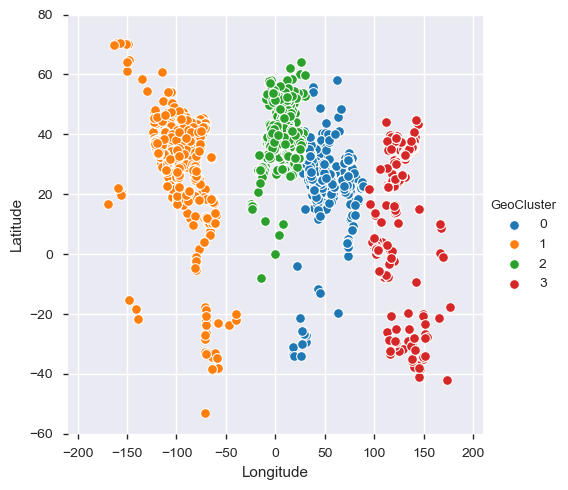

<Figure size 2800x1800 with 0 Axes>

In [41]:
sns.pairplot(x_vars=["Longitude"], y_vars=["Latitude"], data=train, hue="GeoCluster", size=5)
plt.xlim([-210, 210])
plt.ylim([-60, 80])
plt.figure(figsize=(28, 18))

With the clusters defined, we can use leverage the populated data within each field of the training set to keep track of assumed gaussian distribution parameters. This parameter dictionary is maintained only for continuous variables in the dataset. 

In [42]:
cluster_summary = {}
for k in range(4):
    cluster_data = train.iloc[np.where(kmeans.labels_ == k)[0]]
    field_summary = {}
    field_set = ['Capacity (MGD)','Units','Unit size (m3/d)','Inflation Adjusted EPC','Inflation Adjusted Water Cost','Water Stress','Inflation Adjusted Wellhead Natural Gas Price']
    for f in field_set:
        #print(str(k)+f)
        field = cluster_data[f].dropna(inplace=False)
        field_summary[f] = {'mean':field.mean(), 'sdev':field.std()}
    cluster_summary[k] = field_summary

In [43]:
#Sample output from the first cluster
cluster_summary[0]

{'Capacity (MGD)': {'mean': 0.4186865813456882, 'sdev': 0.2663966463796713},
 'Units': {'mean': 1.5238095238095237, 'sdev': 3.5172110782555883},
 'Unit size (m3/d)': {'mean': 831.7744353741494, 'sdev': 1506.5063963616196},
 'Inflation Adjusted EPC': {'mean': 14.230510101450813,
  'sdev': 1.3379857754083413},
 'Inflation Adjusted Water Cost': {'mean': -0.9798105522949999,
  'sdev': 1.4331238669514494},
 'Water Stress': {'mean': 4.367787562901889, 'sdev': 1.1819386458541903},
 'Inflation Adjusted Wellhead Natural Gas Price': {'mean': 1.3133791091459757,
  'sdev': 0.6091776641846308}}

<h3>Imputing Water Costs</h3>
Using the fillWater() function we can pull the average Inflation Adjusted Water Cost for the cluster! 

In [44]:
def fillWater(value,cluster):
    if(value>0):
        return value
    else:
        return cluster_summary.get(cluster).get('Inflation Adjusted Water Cost').get('mean')

def fillWaterStress(value,cluster):
    if(value>0):
        return value
    else:
        return cluster_summary.get(cluster).get('Water Stress').get('mean')
    
def fillNGP(value,cluster):
    if(value>0):
        return value
    else:
        return cluster_summary.get(cluster).get('Inflation Adjusted Wellhead Natural Gas Price').get('mean')

In [45]:
#Fill missing water data
train.loc[:,'Inflation Adjusted Water Cost'] = train.apply(lambda x:fillWater(x['Inflation Adjusted Water Cost'],x['GeoCluster']),axis=1)
train.loc[:,'Water Stress'] = train.apply(lambda x:fillWaterStress(x['Water Stress'],x['GeoCluster']),axis=1)
train.loc[:,'Inflation Adjusted Wellhead Natural Gas Price'] = train.apply(lambda x:fillNGP(x['Inflation Adjusted Wellhead Natural Gas Price'],x['GeoCluster']),axis=1)

Moving to the test set, we predict the Geo Clusters, and then use those unsupervised predictions to impute missing Water Costs too. 

In [46]:
#Set cluster and fill missing water data in test set
test['GeoCluster'] = kmeans.predict(test[['Latitude','Longitude']])
test.loc[:,'Inflation Adjusted Water Cost'] = test.apply(lambda x:fillWater(x['Inflation Adjusted Water Cost'],x['GeoCluster']),axis=1)
test.loc[:,'Water Stress'] = test.apply(lambda x:fillWaterStress(x['Water Stress'],x['GeoCluster']),axis=1)
test.loc[:,'Inflation Adjusted Wellhead Natural Gas Price'] = test.apply(lambda x:fillNGP(x['Inflation Adjusted Wellhead Natural Gas Price'],x['GeoCluster']),axis=1)

Now given the Geo Clusters, we normalize the continuous variables by the standard deviation of that feature across the dataset. It should be known the imputed values will also be normalized by the prior non-null distribution. 

In [47]:
#Normalize continuous variables by standard deviation
def clusterNormalize(value,field,cluster):
    #print('enter')
    return value/(cluster_summary.get(cluster).get(field).get('sdev'))

In [48]:
#test the function output
print(train.iloc[0]['Capacity (MGD)'])
print(train.iloc[0]['GeoCluster'])
clusterNormalize(train.iloc[0]['Capacity (MGD)'],'Capacity (MGD)',train.iloc[0]['GeoCluster'])

0.293560379208524
2


1.079185691454257

In [49]:
for f in ['Capacity (MGD)','Units','Unit size (m3/d)','Inflation Adjusted EPC','Inflation Adjusted Water Cost','Water Stress','Inflation Adjusted Wellhead Natural Gas Price']:
    train_norm = pd.DataFrame(train.apply(lambda x:float(clusterNormalize(x[f],f,x['GeoCluster'])),axis=1)).set_index(train.index)
    train[f] = train_norm
    test_norm = pd.DataFrame(test.apply(lambda x:float(clusterNormalize(x[f],f,x['GeoCluster'])),axis=1)).set_index(test.index)
    test[f] = test_norm

Finally, we can view the test data's Geo Clusters on a plot. 

<Figure size 2800x1800 with 0 Axes>

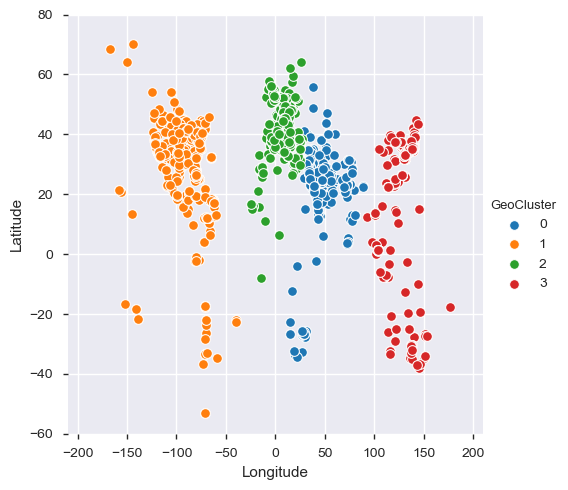

<Figure size 2800x1800 with 0 Axes>

In [50]:
##Need to review this, doesn't look right
sns.pairplot(x_vars=["Longitude"], y_vars=["Latitude"], data=test, hue="GeoCluster", size=5)
plt.xlim([-210, 210])
plt.ylim([-60, 80])
plt.figure(figsize=(28, 18))

<h3>Preparing Data for Regression</h3>
In order to perform a linear regression, we need to transform categorical data into one-hot (0/1) vectors. This code performs that task on both the training and test data sets. This is executed in abstraction, meaning we do not need to be aware of the different values that are included within a categorical feature. 

In [51]:
#Convert relavent features into on-hot-vectors 

print('Converting Customer type to one-hot')
train['Customer type'] = train['Customer type'].replace(np.nan,'Null Customer')
customer_types = train['Customer type'].unique()
for c in customer_types:
    train[c] = train.apply(lambda x:int(x['Customer type'] == c),axis=1)
    test[c] = test.apply(lambda x:int(x['Customer type'] == c),axis=1)

print('Converting Feedwater to one-hot')    
train['Feedwater'] = train['Feedwater'].replace(np.nan,'Null Feedwater')
feedwater = train['Feedwater'].unique()
for c in feedwater:
    train[c] = train.apply(lambda x:int(x['Feedwater'] == c),axis=1)
    test[c] = test.apply(lambda x:int(x['Feedwater'] == c),axis=1)

print('Converting Location Type to one-hot')    
train['Location type'] = train['Location type'].replace(np.nan,'Null Location Type')
loc_type = train['Location type'].unique()
for c in loc_type:
    train[c] = train.apply(lambda x:int(x['Location type'] == c),axis=1)
    test[c] = test.apply(lambda x:int(x['Location type'] == c),axis=1)

print('Converting Plant Type to one-hot') 
train['Plant type'] = train['Plant type'].replace(np.nan,'Null Plant Type')
plant_type = train['Plant type'].unique()
for c in plant_type:
    train[c] = train.apply(lambda x:int(x['Plant type'] == c),axis=1)
    test[c] = test.apply(lambda x:int(x['Plant type'] == c),axis=1)

print('Converting RO Feed Pump Drive to one-hot')    
train['RO Feed Pump Drive'] = train['RO Feed Pump Drive'].replace(np.nan,'Null Feed Pump')
feed_pump = train['RO Feed Pump Drive'].unique()
for c in feed_pump:
    train[c] = train.apply(lambda x:int(x['RO Feed Pump Drive'] == c),axis=1)
    test[c] = test.apply(lambda x:int(x['RO Feed Pump Drive'] == c),axis=1)

print('Converting RO Membrane Type to one-hot')    
train['RO Membrane Type'] = train['RO Membrane Type'].replace(np.nan,'Null Membrane Type')
membrane = train['RO Membrane Type'].unique()
for c in membrane:
    train[c] = train.apply(lambda x:int(x['RO Membrane Type'] == c),axis=1)
    test[c] = test.apply(lambda x:int(x['RO Membrane Type'] == c),axis=1)
    
print('Converting RO System to one-hot')    
train['RO System'] = train['RO System'].replace(np.nan,'Null RO System')
system = train['RO System'].unique()
for c in system:
    train[c] = train.apply(lambda x:int(x['RO System'] == c),axis=1)
    test[c] = test.apply(lambda x:int(x['RO System'] == c),axis=1)

print('Converting Size to one-hot')    
train['Size'] = train['Size'].replace(np.nan,'Null Size')
sizes = train['Size'].unique()
for c in membrane:
    train[c] = train.apply(lambda x:int(x['Size'] == c),axis=1)
    test[c] = test.apply(lambda x:int(x['Size'] == c),axis=1)

print('Converting Technology to one-hot')    
train['Technology'] = train['Technology'].replace(np.nan,'Null Technology')
tech = train['Technology'].unique()
for c in membrane:
    train[c] = train.apply(lambda x:int(x['Technology'] == c),axis=1)
    test[c] = test.apply(lambda x:int(x['Technology'] == c),axis=1)

Converting Customer type to one-hot
Converting Feedwater to one-hot
Converting Location Type to one-hot
Converting Plant Type to one-hot
Converting RO Feed Pump Drive to one-hot
Converting RO Membrane Type to one-hot
Converting RO System to one-hot
Converting Size to one-hot
Converting Technology to one-hot


Here we drop any numeric fields from our prior cleaning that are no longer necessary, and set the same fields to the test set. 

In [52]:
# pd.describe returns the numeric fields, .keys() returns those field names. Then drop the dirty or useless fields
train_numeric = train[train.describe().keys()].drop(columns=['Award date','EPC price','Plant supplier share','Online date','Water price (USD/m3)','Water Year','Water Cost','Water Inflation Multiple'])

In [53]:
#use the same fields for the test set
test_numeric = test[train_numeric.keys()]

<h3>Feature Selection</h3>
1. Built a correlation matrix and removed highly correlated features with a rho > 0.7
2. Split the data into prediction and prediction (_X and _Y sets)
3. Built OLS regression and reviewed p-values. Removed fields with a p-value > 0.5 or null p-value. Interestingly Water Cost provided a p-value of ~0.3, but we know it is important to the equation so we relaxed the critical value threshold to include it. 
4. Rebuilt the OLS regression using refined predictors
5. Reviewed the correlation matrix of new predictor set and removed another highly correlated feature (Null Location Type)

In [54]:
#create correlation matrix
corr_matrix = train_numeric.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

In [55]:
if('Inflation Adjusted EPC' in to_drop):
    to_drop.remove('Inflation Adjusted EPC')
if('Capacity (MGD)' in to_drop):
    to_drop.remove('Capacity (MGD)')
to_drop

['Unit size (m3/d)',
 'Offshore',
 'Null Plant Type',
 'Electric Motor',
 'Null RO System',
 'Single Pass']

In [56]:
# type(df['Capacity (MGD)'][0])

In [57]:
train_numeric = train_numeric.drop(columns=to_drop)
train_numeric.dropna(inplace=True)
test_numeric = test_numeric.drop(columns=to_drop)
test_numeric.dropna(inplace=True)

train_X = train_numeric.drop(columns=['Inflation Adjusted EPC'])
train_Y = train_numeric['Inflation Adjusted EPC']
test_X = test_numeric.drop(columns=['Inflation Adjusted EPC'])
test_Y = test_numeric['Inflation Adjusted EPC']

In [58]:
train_numeric.head()

,Capacity (m3/d),Capacity (MGD),Inflation Adjusted EPC,Inflation Adjusted Wellhead Natural Gas Price,Latitude,Longitude,Units,Water Stress,Inflation Adjusted Water Cost,GeoCluster,...,Stand-alone,Dual Purpose,Null Feed Pump,Null Membrane Type,Hollow Fibre Membrane,Spiral Wound Membrane,Tube Membrane,Flat membrane (FM),Dual membrane plant (HFM/SWM),Two Pass
0,326.0,1.079186,11.987576,2.171782,53.766667,-2.716667,1.735453,2.89791,-1.593123,2,...,1,0,1,0,0,0,0,0,0,0
2,1005.0,1.797269,12.700973,2.171782,54.950000,-1.650000,4.338632,2.89791,-1.593123,2,...,1,0,1,0,0,0,0,0,0,0
3,806.0,1.605031,12.517333,2.171782,51.466667,-0.150000,1.735453,2.89791,-1.593123,2,...,1,0,1,0,0,0,0,0,0,0
5,110.0,0.632036,11.006839,2.171782,52.000000,-2.416667,0.867726,2.89791,-1.593123,2,...,1,0,1,0,0,0,0,0,0,0
6,114.0,0.632036,10.946210,2.171782,53.400000,-3.033333,0.867726,2.89791,-1.593123,2,...,1,0,1,0,0,0,0,0,0,0


In [59]:
import statsmodels.api as sm
X = sm.add_constant(train_X)
model = sm.OLS(train_Y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Inflation Adjusted EPC   R-squared:                       0.848
Model:                                OLS   Adj. R-squared:                  0.847
Method:                     Least Squares   F-statistic:                     1013.
Date:                    Sun, 02 Dec 2018   Prob (F-statistic):               0.00
Time:                            01:58:01   Log-Likelihood:                -3680.1
No. Observations:                    4756   AIC:                             7414.
Df Residuals:                        4729   BIC:                             7589.
Df Model:                              26                                         
Covariance Type:                nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
const                                                                    7.4582      0.182     40.960      0.000       7.101       7.815
Capacity (m3/d)                                                      -5.188e-05   3.33e-06    -15.577      0.000   -5.84e-05   -4.54e-05
Capacity (MGD)                                                           0.9634      0.013     75.245      0.000       0.938       0.989
Inflation Adjusted Wellhead Natural Gas Price                           -0.2500      0.010    -25.129      0.000      -0.270      -0.230
Latitude                                                                -0.0004      0.001     -0.584      0.559      -0.002       0.001
Longitude                                                               -0.0080      0.000    -53.751      0.000      -0.008      -0.008
Units                                                                    0.0362      0.008      4.315      0.000       0.020       0.053
Water Stress                                                             0.0487      0.009      5.344      0.000       0.031       0.067
Inflation Adjusted Water Cost                                            0.8964      0.018     49.877      0.000       0.861       0.932
GeoCluster                                                               0.7042      0.009     81.074      0.000       0.687       0.721
Power stations (TDS <10ppm)                                              1.3485      0.038     35.615      0.000       1.274       1.423
Industry (TDS <10ppm)                                                    1.1924      0.033     36.627      0.000       1.129       1.256
Municipalities as drinking water (TDS 10ppm - <1000ppm)                  1.1576      0.035     33.262      0.000       1.089       1.226
Tourist facilities as drinking water (TDS 10ppm - <1000ppm)              1.0331      0.042     24.648      0.000       0.951       1.115
Demonstration                                                            1.2818      0.079     16.312      0.000       1.128       1.436
Irrigation (TDS <1000ppm)                                                0.8511      0.050     17.034      0.000       0.753       0.949
Discharge                                                                0.5936      0.081      7.337      0.000       0.435       0.752
Brackish water or inland water (TDS 3000ppm - <20000ppm)                 1.0801      0.036     30.054      0.000       1.010       1.151
River water or low concentrated saline water (TDS 500ppm - <3000ppm)     0.9307      0.041     22.512      0.000       0.850       1.012
Seawater (TDS 20000ppm - 

In [60]:
train_X = train_X[((model.pvalues.notna()) & (model.pvalues < 0.5))[((model.pvalues.notna()) & (model.pvalues < 0.5))==True].keys().drop('const')]
test_X = test_X[((model.pvalues.notna()) & (model.pvalues < 0.5))[((model.pvalues.notna()) & (model.pvalues < 0.5))==True].keys().drop('const')]

In [61]:
X = sm.add_constant(train_X)
model = sm.OLS(train_Y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Inflation Adjusted EPC   R-squared:                       0.848
Model:                                OLS   Adj. R-squared:                  0.847
Method:                     Least Squares   F-statistic:                     1197.
Date:                    Sun, 02 Dec 2018   Prob (F-statistic):               0.00
Time:                            01:58:01   Log-Likelihood:                -3680.4
No. Observations:                    4756   AIC:                             7407.
Df Residuals:                        4733   BIC:                             7556.
Df Model:                              22                                         
Covariance Type:                nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
const                                                                    7.5182      0.133     56.685      0.000       7.258       7.778
Capacity (m3/d)                                                      -5.179e-05    3.3e-06    -15.680      0.000   -5.83e-05   -4.53e-05
Capacity (MGD)                                                           0.9633      0.013     75.414      0.000       0.938       0.988
Inflation Adjusted Wellhead Natural Gas Price                           -0.2497      0.010    -25.204      0.000      -0.269      -0.230
Longitude                                                               -0.0080      0.000    -53.832      0.000      -0.008      -0.008
Units                                                                    0.0360      0.008      4.295      0.000       0.020       0.052
Water Stress                                                             0.0500      0.009      5.592      0.000       0.032       0.067
Inflation Adjusted Water Cost                                            0.9006      0.016     55.024      0.000       0.869       0.933
GeoCluster                                                               0.7042      0.009     81.179      0.000       0.687       0.721
Power stations (TDS <10ppm)                                              1.3574      0.033     41.060      0.000       1.293       1.422
Industry (TDS <10ppm)                                                    1.2005      0.028     43.407      0.000       1.146       1.255
Municipalities as drinking water (TDS 10ppm - <1000ppm)                  1.1664      0.030     39.185      0.000       1.108       1.225
Tourist facilities as drinking water (TDS 10ppm - <1000ppm)              1.0431      0.038     27.590      0.000       0.969       1.117
Demonstration                                                            1.2890      0.076     16.884      0.000       1.139       1.439
Irrigation (TDS <1000ppm)                                                0.8610      0.047     18.363      0.000       0.769       0.953
Discharge                                                                0.6008      0.079      7.622      0.000       0.446       0.755
Brackish water or inland water (TDS 3000ppm - <20000ppm)                 1.0904      0.029     37.083      0.000       1.033       1.148
River water or low concentrated saline water (TDS 500ppm - <3000ppm)     0.9398      0.036     26.424      0.000       0.870       1.009
Seawater (TDS 20000ppm - 50000ppm)                                       1.6673      0.032     52.766      0.000       1.605       1.729
Brine or concentrated sea

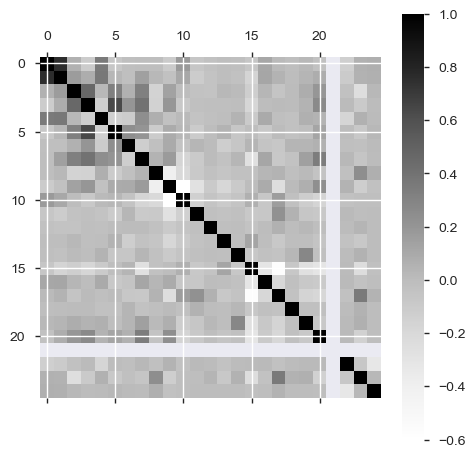

In [62]:
plt.matshow(train_X.corr())
plt.colorbar()

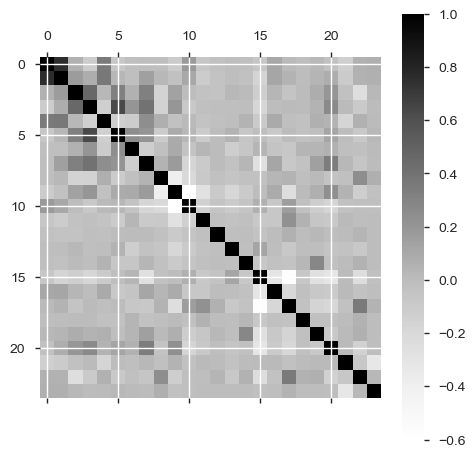

In [63]:
train_X = train_X.drop(columns='Null Location Type')
test_X = test_X.drop(columns='Null Location Type')
plt.matshow(train_X.corr())
plt.colorbar()

<h3>Model Fitting and Evaluation</h3>
Using sklearn's LinearRegression() we build an OLS model against the training data. Although this yields an R^2 of 0.56, the RMSE of percent differences in the test set is quite high (+200%). This is likely attributed to overfitting in the training set of high prices plants compared to the test set's lower priced plants. Looking at the output in a graph, the model seems reasonable. 

One important point to recall is that at this point we are still predicting the normalized Inflation Adjusted EPC (normalized by the Geo Cluster). 

R^2 = 0.8477047862181922
RMSE = 0.04665994461616356


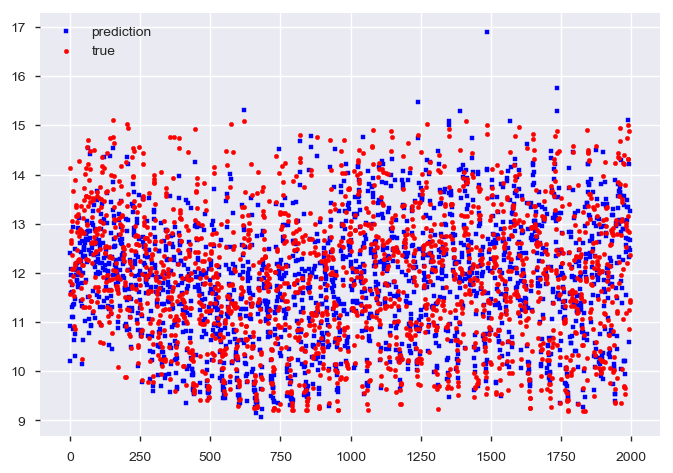

In [64]:
from math import sqrt
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(train_X,train_Y)
#Score returns the regression R^2
print('R^2 = ' + str(model.score(train_X,train_Y)))

prediction_Y = model.predict(test_X)
print('RMSE = '+str(sqrt(((prediction_Y-test_Y)/test_Y).apply(lambda x:x**2).mean())))

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(range(len(prediction_Y)), prediction_Y, s=10, c='b', marker="s", label='prediction')
ax1.scatter(range(len(test_Y)),test_Y, s=10, c='r', marker="o", label='true')
plt.legend(loc='upper left');
plt.show()

### CROSS VALIDATION

<h3>User Interface</h3>
1. User inputs each of the relevant features inline
2. Predict the new plant's Geo Cluster using Latitude and Longitude
3. Use the Geo Cluster to normalize the continuous input variables
4. Iterate through the training set features compared to user inputs to produce a one-hot feature set

In [65]:
#Sample raw data we will pass back into the model
#mdf.iloc[1][['Inflation Adjusted EPC','Capacity (MGD)','Latitude','Longitude','Units','Inflation Adjusted Water Cost','Inflation Adjusted Wellhead Natural Gas Price','Water Stress','Customer type','Feedwater','Location type','Plant type','RO Membrane Type','RO System','Size','Technology']]
mdf.iloc[1]

Award date                                                                                       1946
Capacity (m3/d)                                                                                   302
Capacity (MGD)                                                                               0.277419
Capital Cost per Unit of Daily Capacity ($/m3/d)                                          29481.66186
Country                                                                                         India
Customer type                                       Municipalities as drinking water (TDS 10ppm - ...
EPC contractor (desal)                                                                            NaN
EPC price                                                                                      810000
Feedwater                                                          Seawater (TDS 20000ppm - 50000ppm)
Holding Company                                                                   

In [66]:
cp = input("Enter Capacity (MGD) (as float) ")
lt = input("Enter Latitude (as float) ")
lg = input("Enter Longitude (as float) ")
ut = input("Enter Units (as float) ")
iaw = input("Enter Inflation Adjusted Water Cost (as float) ")
iaw = math.log(float(iaw))
iawngp = input("Enter Inflation Adjusted Wellhead Natural Gas Price (as float) ")
iawngp = math.log(float(iawngp))
ws = input("Enter Water Stress (as float) ")

print('Supported Customer Types')
customer_t = np.append(customer_types,['Other'])
i = 0
for c in customer_t:
    print('-- '+str(i)+') '+str(c))
    i += 1
ct = input("Enter Customer Type (as integer) ")

print('Supported Feedwaters')
feedwater_t = np.append(feedwater,['Other'])
i = 0
for c in feedwater_t:
    print('-- '+str(i)+') '+str(c))
    i += 1
ft = input("Enter Feedwater (as integer) ")

print('Supported Location Types')
location_t = np.append(loc_type,['Other'])
i = 0
for c in location_t:
    print('-- '+str(i)+') '+str(c))
    i += 1
loct = input("Enter Location Type (as integer) ")

print('Supported Plant Types')
plant_t = np.append(plant_type,['Other'])
i = 0
for c in plant_t:
    print('-- '+str(i)+') '+str(c))
    i += 1
pt = input("Enter Plant Type (as integer) ")

print('Supported Membrane Types')
memb_t = np.append(membrane,['Other'])
i = 0
for c in memb_t:
    print('-- '+str(i)+') '+str(c))
    i += 1
mt = input("Enter Membrane Type (as integer) ")

print('Supported System Types')
sys_t = np.append(system,['Other'])
i = 0
for c in sys_t:
    print('-- '+str(i)+') '+str(c))
    i += 1
syt = input("Enter System Type (as integer) ")

print('Supported Sizes')
size_t = np.append(sizes,['Other'])
i = 0
for c in size_t:
    print('-- '+str(i)+') '+str(c))
    i += 1
st = input("Enter Size (as integer) ")

print('Supported Technology Types')
tech_t = np.append(tech,['Other'])
i = 0
for c in tech_t:
    print('-- '+str(i)+') '+str(c))
    i += 1
tt = input("Enter Technology Type (as integer) ")


KeyboardInterrupt: 

In [ ]:
#reprinting here for ease of reference on input
mdf.iloc[1]

In [ ]:
#input_frame = pd.DataFrame(columns=['Capacity (MGD)','Latitude','Longitude','Units','Inflation Adjusted Water Cost','Inflation Adjusted Wellhead Natural Gas Price','Water Stress','GeoCluster'])
input_frame = pd.DataFrame(columns=['Capacity (MGD)', 'Inflation Adjusted Wellhead Natural Gas Price',
       'Longitude', 'Units', 'Water Stress', 'Inflation Adjusted Water Cost',
       'GeoCluster'])
geo_frame = pd.DataFrame(columns=['Latitude','Longitude'])
geo_frame.loc[0] = [float(lt),float(lg)]
geo = kmeans.predict(geo_frame[['Latitude','Longitude']])[0]
input_frame.loc[0] = [float(cp),float(iawngp),float(lg),float(ut),float(ws),float(iaw),geo]

In [ ]:
train_X.keys()

In [ ]:
#one_hot = list()
for t in train_X.keys()[7:]:
    print(t)
    if(t == customer_t[int(ct)]):
        one_hot=1
    elif(t == feedwater_t[int(ft)]):
        one_hot=1
    elif(t == location_t[int(loct)]):
        one_hot=1
    elif(t == plant_t[int(pt)]):
        one_hot=1
    elif(t == memb_t[int(mt)]):
        one_hot=1
    elif(t == sys_t[int(syt)]):
        one_hot=1
    elif(t == size_t[int(st)]):
        one_hot=1
    elif(t == tech[int(tt)]):
        one_hot=1
    else:
        one_hot=0
    input_frame[t] = one_hot

input_frame.iloc[0]

In [ ]:
for f in ['Capacity (MGD)','Units','Inflation Adjusted Water Cost','Inflation Adjusted Wellhead Natural Gas Price','Water Stress']:
    input_norm = pd.DataFrame(input_frame.apply(lambda x:float(clusterNormalize(x[f],f,x['GeoCluster'])),axis=1)).set_index(input_frame.index)
    input_frame[f] = input_norm

Important! After we make our prediction, we need to use unnormalizeEPC to scale back up to USD using the Geo Clusters standard deviation of Inflation Adjusted EPC. 

In [ ]:
def unnormalizeEPC(pred,field,cluster):
    return math.exp(pred*(cluster_summary.get(cluster).get(field).get('sdev')))

In [ ]:
input_frame

In [ ]:
expected_cost = unnormalizeEPC(model.predict(input_frame)[0],'Inflation Adjusted EPC',input_frame['GeoCluster'][0])
print('Your salination plant is expected to have an EPC of $'+"{:,}".format(round(expected_cost,2)))

In [ ]:
math.exp(mdf.iloc[1])

In [69]:
from sklearn.model_selection import KFold

kf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None) 

for train_index, test_index in kf.split(X):
      print("Train:", train_index, "Validation:",test_index)

X_train, X_test = X[train_index], X[test_index] 
y_train, y_test = y[train_index], y[test_index]

NameError: name 'RepeatedKFold' is not defined

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import numpy as np

iris = load_iris()
X = iris.data
y = iris.target

pipe_svc = Pipeline([('scl', StandardScaler()),
            ('clf', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

param_grid = [{'clf__C': param_range, 'clf__gamma': param_range, 'clf__kernel': ['rbf']}]

N_outer=10
N_inner=10

scores=[]
for i in range(N_outer):
    k_fold_outer = StratifiedKFold(n_splits=10,shuffle=True,random_state=i)
    for j in range(N_inner):
        k_fold_inner = StratifiedKFold(n_splits=10,shuffle=True,random_state=j)
        gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=k_fold_inner)
        score=cross_val_score(estimator=gs,X=X,y=y,cv=k_fold_outer)
        scores.append(score)

np.shape(scores)

KeyboardInterrupt: 

In [72]:
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [73]:
# Perform 6-fold cross validation
scores = cross_val_score(model, train_X, train_Y, cv=6)
print ("Cross-validated scores:", scores)


Cross-validated scores: [0.36687313 0.80281755 0.81491067 0.87124514 0.8247364  0.82546346]


Cross-Predicted Accuracy: 0.8309094033991393


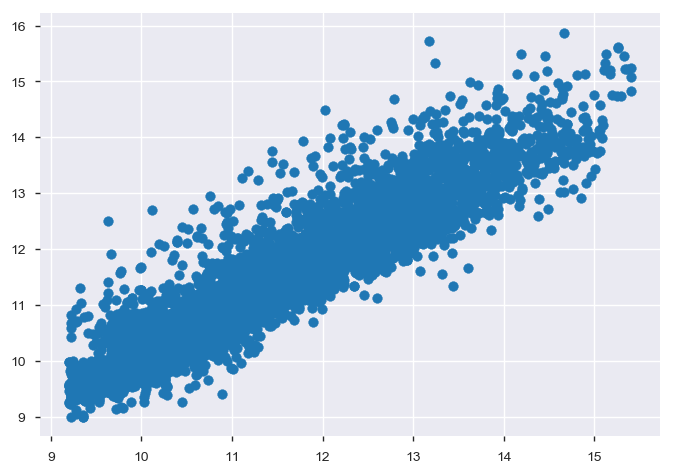

In [84]:
# Make cross validated predictions
predictions = cross_val_predict(model, train_X, train_Y, cv=15)
plt.scatter(train_Y, predictions)

accuracy = metrics.r2_score(train_Y, predictions)
print ("Cross-Predicted Accuracy:", accuracy)
# Cross-Predicted Accuracy: 0.490806583864

Cross-Predicted Accuracy: 0.8232167591482895


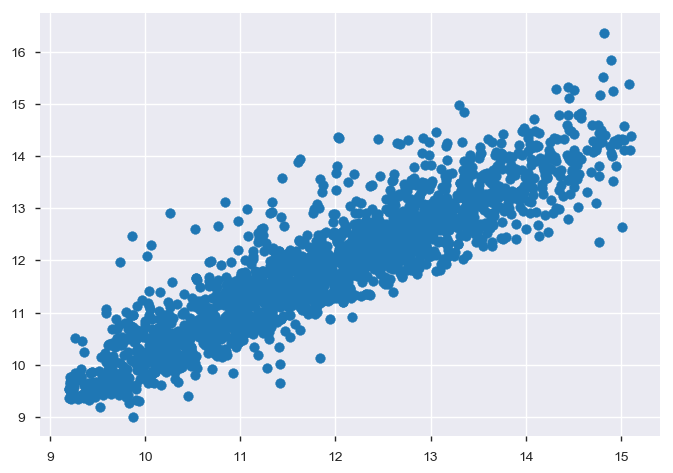

In [83]:
# Make cross validated predictions
predictions = cross_val_predict(model, test_X, test_Y, cv=15)
plt.scatter(test_Y, predictions)

accuracy = metrics.r2_score(test_Y, predictions)
print ("Cross-Predicted Accuracy:", accuracy)
# Cross-Predicted Accuracy: 0.490806583864

In [85]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, ground_truth_data, 
    test_size=0.3,random_state =1 )
# model = linear_model.LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(model,parameters, cv=None)
grid.fit(train_X, train_Y)
print ("r2 / variance : ", grid.best_score_)
print("Residual sum of squares: %.2f"
              % np.mean((grid.predict(test_X) - test_Y) ** 2))

r2 / variance :  0.7618527481326641
Residual sum of squares: 0.31
